In [3]:
import pickle5 as pickle
import matplotlib.pyplot as pl
import sys
import numpy as np
import glob
import re
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore")

import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')

In [4]:
jexosim_outpath = '/Users/tgordon/research/exomoons_jwst/JexoSim/output/'
files = glob.glob(jexosim_outpath + '*_params_*_11_params*.pickle')

In [429]:
def min_depth_ppm(sigma, ppm):
    return sigma * ppm

def var(w0, d):
    e1 = np.sqrt(2) * d * w0
    f1 = 1 / (d * d * w0 * np.sqrt(2))
    f2 = 1 * np.exp(-e1) * np.cos(e1 + np.pi / 4) / (d * d * w0)
    f3 = 2  * np.exp(-e1) *np.cos(e1/2 + np.pi / 4) / (d * d * w0)
    return f1 + f2 - f3  

def mvar(s0, w0, d, alpha, sigma):
    alpha = s0 * alpha[:, None] * np.sqrt(var(w0, d))
    sum = np.sum(alpha, axis=0)
    sum2 = np.sum(alpha**2, axis=0)
    num = sigma * sigma + sum2
    denom = len(alpha) * (1 + sum2 / (sigma * sigma)) - (sum / sigma) ** 2
    return  num / denom

def var1(s0, w0, d, alpha, sigma):
    alpha = s0 * alpha[:, None] * np.sqrt(var(w0, d))
    sum = np.sum(alpha, axis=0)
    return sigma * sigma / len(alpha) + (sum / len(alpha))**2

def min_depth_ppm_correlated(wl, sigma, ppm, alpha, mono=False):
    d = 10 * 60 * 60
    w0 = 866
    if mono:
        return np.sqrt(var1(1, w0, d, alpha, sigma))
    else:
        return np.sqrt(mvar(1, w0, d, alpha, sigma)) * ppm

def rad(teff, isofile):
    iso = read_mist_models.ISO(isofile)
    age_ind = iso.age_index(9.0)
    isoteff = 10 ** (iso.isos[age_ind]['log_Teff'])
    isor = 10 ** (iso.isos[age_ind]['log_R'])
    cuts = (isoteff < 7200) & (isor < 2)
    radfunc = interp1d(isoteff[cuts], isor[cuts])
    return radfunc(teff)

def read_jexo(files):
    teffs = np.zeros(len(files))
    noise = np.zeros(len(files))
    for i, f in enumerate(files):
        txtfile = f + '.txt'
        tint = float(open(txtfile, 'r').readlines()[17].split(' ')[2])
        dt = float(open(txtfile, 'r').readlines()[18].split(' ')[2])
        ng = float(open(txtfile, 'r').readlines()[19].split(' ')[5][0])
        apfactor = float(open(txtfile, 'r').readlines()[24].split(' ')[2][:-1])
        teff, met, logg, jmag = f.split('params')[1].split('_')[1:-1]
        result = pickle.load(open(f, 'rb'))
        wl = result['noise_dic']['All noise']['wl']
        means = result['noise_dic']['All noise']['signal_mean_stack']
        stds = result['noise_dic']['All noise']['signal_std_stack']
        wn = (np.sqrt(np.sum(stds ** 2)) / np.sum(means))
        n_exp = 10 * 60 * 60 / dt
        noise[i] =  wn / np.sqrt(n_exp) * 1e6
        teffs[i] = teff
    return wl, teffs, noise

Reading in: ../mist_met_0.0.iso
Reading in: ../mist_met_0.0.iso
Reading in: ../mist_met_0.0.iso
[0.14878864 0.32734558 0.55511451 0.66309525 0.74668844 0.84380918
 1.01134072 1.25107106 1.513664  ]


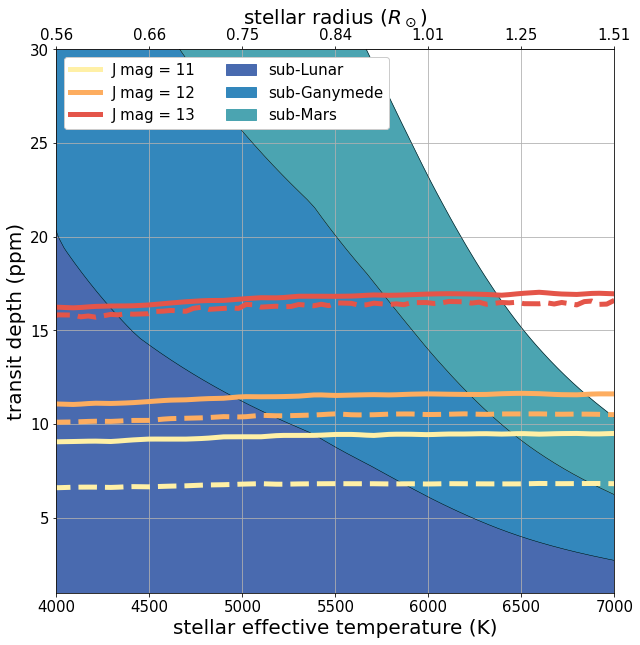

In [431]:
from matplotlib.ticker import FormatStrFormatter
pl.figure(figsize=(10, 10))
teffgrid = np.linspace(3000, 7000, 500)

radgrid = rad(teffgrid, '../mist_met_0.0.iso')
benchmarks = 0.0025, 0.00378, 0.00487
pl.fill_between(teffgrid, -5 * np.ones_like(teffgrid), 
                1e6 * (benchmarks[0] / radgrid) ** 2, 
                color=cmap(0.95), alpha=1, label='sub-Lunar')
pl.fill_between(teffgrid, 1e6 * (benchmarks[0] / radgrid) ** 2, 
                1e6 * (benchmarks[1] / radgrid) ** 2, 
                color=cmap(0.9), alpha=1, label='sub-Ganymede')
pl.fill_between(teffgrid, 1e6 * (benchmarks[1] / radgrid) ** 2, 
                1e6 * (benchmarks[2] / radgrid) ** 2, 
                color=cmap(0.85), alpha=1, label='sub-Mars')
pl.plot(teffgrid, 1e6 * (benchmarks[0] / radgrid) ** 2, color='k', linewidth=0.5)
pl.plot(teffgrid, 1e6 * (benchmarks[1] / radgrid) ** 2, color='k', linewidth=0.5)
pl.plot(teffgrid, 1e6 * (benchmarks[2] / radgrid) ** 2, color='k', linewidth=0.5)

for i, mag in enumerate([11, 12, 13]):
    files = glob.glob(jexosim_outpath + '*_params_*_{0}_params*.pickle'.format(mag))
    wl, teffs, noise = read_jexo(files)
    teffgrid = np.linspace(3000, 7000, 100)
    interp_noise = interp1d(teffs, noise)
    noise = interp_noise(teffgrid)
    pl.plot(teffgrid, min_depth_ppm(5, noise), '--', color=cmap(0.45-i*0.15), linewidth=5)
    
for i, mag in enumerate([11, 12, 13]):
    files = glob.glob(jexosim_outpath + 'nosat/*_params_*_{0}_params*.pickle'.format(mag))
    wl, teffs, noise = read_jexo(files)
    teffgrid = np.linspace(3000, 7000, 100)
    interp_noise = interp1d(teffs, noise)
    noise = interp_noise(teffgrid)
    pl.plot(teffgrid, min_depth_ppm(5, noise), color=cmap(0.45-i*0.15), linewidth=5, label="J mag = {0}".format(mag))

pl.ylim(1, 30)
pl.xlabel('stellar effective temperature (K)', fontsize=20)
pl.ylabel('transit depth (ppm)', fontsize=20)

ax2 = pl.gca().secondary_xaxis('top')
topx = rad(pl.gca().get_xticks()[1:-1], '../mist_met_0.0.iso')
print(rad(pl.gca().get_xticks()[1:-1], '../mist_met_0.0.iso'))
topx = ["{:.2f}".format(x) for x in topx[2:]]
ax2.set_xticklabels(topx, fontsize=15)
pl.xticks(fontsize=15)
pl.yticks(fontsize=15)
pl.xlim(4000, 7000)
ax2.set_xlabel(r"stellar radius ($R_\odot$)", fontsize=20)
pl.grid(axis='both', which='both')
pl.legend(loc='upper left', fontsize=15, framealpha=1, ncol=2)
pl.savefig('/Users/tgordon/Desktop/detection_limits.pdf')

In [596]:
import sys
sys.path.append('../utils/')
import genfactors
import imp
imp.reload(genfactors)

<module 'genfactors' from '../utils/genfactors.py'>

In [629]:
result = pickle.load(open(files[0], 'rb'))
wl = result['noise_dic']['All noise']['wl']
stds = result['noise_dic']['All noise']['signal_std_stack']
alpha = genfactors.variability_factors(wl, cold_temp=5600, hot_temp=5800, 
                                       effective_temp=5600, spec_path='../JexoSim/archive')
alpha = genfactors.equal_wn_bins(alpha, stds, nbins=10)

In [628]:
#alpha

array([2.23180309, 1.64150198, 1.34432189, 1.02439908, 0.71138589,
       0.59211415, 0.59137798, 0.65101933, 0.54906706, 0.66300956])

In [630]:
alpha = alpha / np.mean(alpha)
alpha

array([2.23180309, 1.64150198, 1.34432189, 1.02439908, 0.71138589,
       0.59211415, 0.59137798, 0.65101933, 0.54906706, 0.66300956])

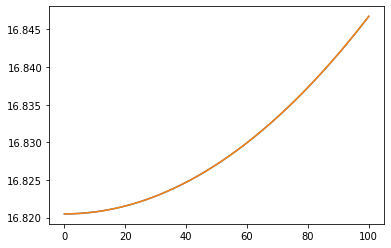

In [645]:
txtfile = files[0] + '.txt'
tint = float(open(txtfile, 'r').readlines()[17].split(' ')[2])
dt = float(open(txtfile, 'r').readlines()[18].split(' ')[2])
n_exp = 10 * 60 * 60 / dt
means = result['noise_dic']['All noise']['signal_mean_stack']
wn = (np.sqrt(np.sum(stds ** 2)) / np.sum(means))
wn /= np.sqrt(n_exp)

x = np.linspace(0, 100, 1000)
s0 = x * wn
d = 10 * 60 * 60
w0 = 2 * np.pi / (0.1 * d)
#alpha = np.array([1, 1.5, 2.0])
pl.plot(x, 5*np.sqrt(mvar(s0, w0, d, alpha, wn * np.sqrt(len(alpha)))) * 1e6)
pl.plot(x, 5*np.sqrt(var1(s0, w0, d, alpha, wn* np.sqrt(len(alpha)))) * 1e6)

In [588]:
1.04 * 5600

5824.0

In [519]:
files[0]

'/Users/tgordon/research/exomoons_jwst/JexoSim/output/nosat/OOT_SNR_NIRSpec_BOTS_PRISM_params_5300_1.0_4.5_13_params_2020_12_09_1842_09.pickle'

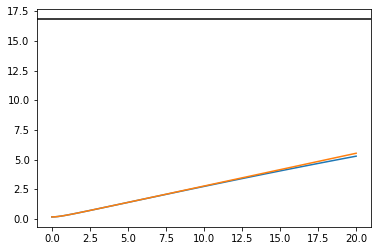

In [485]:
wl, teff, noise = read_jexo(files)
noise *= 1e-6

x = np.linspace(0, 20, 100)
s0 = x * noise[0]
tau = 100 * 60 * 60
w0 = 2 * np.pi / tau
d = 1 * 60 * 60
sigma = 0.01*noise[0] * np.sqrt(len(alpha))

pl.plot(x, 5*np.sqrt(mvar(s0, w0, d, alpha, sigma)) * 1e6)
pl.plot(x, 5*np.sqrt(var1(s0, w0, d, alpha, sigma)) * 1e6)
pl.axhline(5 * noise[0] * 1e6, color='k')

In [32]:
import sys
sys.path.append('../')
import read_mist_models

iso = read_mist_models.ISO('../mist_met_0.0.iso')
age_ind = iso.age_index(9.0)
Teff = 10 ** (iso.isos[age_ind]['log_Teff'])
R = 10 ** (iso.isos[age_ind]['log_R'])
logg = iso.isos[age_ind]['log_g']
mass = iso.isos[age_ind]['initial_mass']

Reading in: ../mist_met_0.0.iso


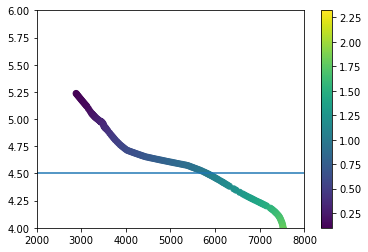

In [35]:
pl.scatter(Teff, logg, c=mass)
pl.xlim(2000, 8000)
pl.ylim(4, 6)
pl.axhline(4.5)

In [221]:
from scipy.interpolate import interp1d
cuts = (Teff < 8000) & (R < 2)
getrad = interp1d(Teff[cuts], R[cuts])
teffgrid = np.linspace(3000, 7000, 1000)
rads = getrad(teffgrid)
#pl.plot(Teff[cuts], R[cuts], '.')

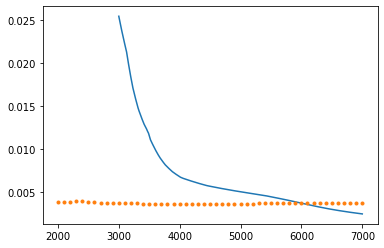

In [235]:
pl.plot(teffgrid, 0.00378 / rads, '-')
pl.plot(teffs, minrad(noise), '.')
#pl.ylim(0.003, 0.005)

In [226]:
rads

array([0.14878864, 0.14963224, 0.15047584, 0.15131944, 0.1521738 ,
       0.15303843, 0.15390306, 0.15476768, 0.15563231, 0.15649693,
       0.15737817, 0.15826458, 0.159151  , 0.16003741, 0.16092382,
       0.16181024, 0.16271575, 0.16362393, 0.16453212, 0.1654403 ,
       0.16634848, 0.16726212, 0.16819195, 0.16912177, 0.17005159,
       0.17098142, 0.17191124, 0.17285573, 0.17380683, 0.17475793,
       0.17570903, 0.17666013, 0.17782559, 0.17939237, 0.18095916,
       0.18252594, 0.18409273, 0.18565951, 0.1872263 , 0.18879308,
       0.19035987, 0.192004  , 0.19367982, 0.19535563, 0.19703144,
       0.19870726, 0.20038307, 0.20205888, 0.2037347 , 0.20541051,
       0.20713971, 0.20891124, 0.21068277, 0.2124543 , 0.21422583,
       0.21599736, 0.21776888, 0.21954041, 0.22120341, 0.222759  ,
       0.2243146 , 0.22588968, 0.22747174, 0.2290538 , 0.23065566,
       0.23226467, 0.23387369, 0.23550637, 0.23714195, 0.23878035,
       0.24044379, 0.24210722, 0.24377404, 0.24546566, 0.24715

In [748]:
def per(dur, r, m):
    dur *= (60 * 60)
    period = dur * np.pi * ((ac.G.value * ac.M_sun.value * m) ** (1/3)) / ((4 * np.pi * np.pi) ** (1/3)) / (r * ac.R_sun.value)
    period = period **3
    return period / (60 * 60 * 24)

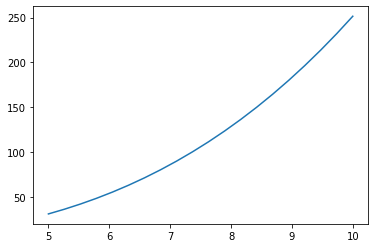

In [792]:
pl.plot(np.linspace(5, 10, 20), per(np.linspace(5, 10, 20), 0.83, 0.86))